# Mean solvation across membrane
In this notebook, 
I calculate and Plot the mean solvation 
(mean number of solvent particles from `gmx mindist` called `numcont`)
as a function of the distance from the membrane center (from `pullx`).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, fnmatch
import pickle


In [2]:
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result


def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)


In [3]:
class Simulation:
    """
    class that is very specific to the use with my permeability project.
    It uses pre-analyzed results from Gromacs
    to calculate the mean hydration along the membrane normal.
    """
    def __init__(self, pullx_fname='pullx.xvg', numcont_fname="numcont_particle-solvent.xvg"):
        self.dirname       = os.path.dirname(pullx_fname)
        self.pullx_fname   = pullx_fname
        self.numcont_fname = numcont_fname
        
        
    def load_df(self, fname, columns, app_func=None):
        """
        methods loads a xvg file (expecting only two columns) 
        and turnes it into a dataframe with the described column names.
        columns shall be a list of column names.
        app_func is a name of a function to be applied on the resulting DataFrame
        """
        arr = np.loadtxt(fname, dtype=float, comments=["#", "@"])
        df  = pd.DataFrame(arr, columns=columns).set_index(columns[0])
        if app_func:
            df = df.apply(app_func)
            
        return df

    
    def merge2dfs(self, df1, df2, on_index='t'):
        "simply merge two dataframes o the specified index name"
        return df1.merge(df2, on=on_index)
    
    
    def load_xnt_df(self):
        """
        loads in necessarry data to return 
        a DataFrame containing the x - numcont values 
        with t as index
        """
        df = self.merge2dfs(self.load_df(self.pullx_fname, columns=['t', 'x'], app_func=abs),
                                   self.load_df(self.numcont_fname, columns=['t', 'numcont']))
        #df.numcont = df.numcont.apply(int)
        return df
      
        
    @property
    def mean_solv(self):
        try:
            return self.__mean_solv_df
        except:
            return self.calc_mean_solv()
            

    @property
    def degree_of_solv(self):
        """
        using a definition that 0=dry ; 1=in contact with solvent
        the average value tells on the probability of 
        being dry -vs- in contact with at least one solvent molecule. 
        """
        try:
            return self.__degree_of_solv_df
        except:
            return self.calc_mean_solv(degree_of_solv=True)
            
    
    def calc_mean_solv(self, bins=40, degree_of_solv=False):
        """
        calculate the profile of mean solvation (incl. std).
        input DataFrame has to have a column 'x'
        and
        calculate the degree of solbvation - stores as a hidden variable
        """
        # load the files to make the x-numcont(t) DataFrame
        xnbinst = self.load_xnt_df()
        # perform binning (equal sizes)
        xnbinst['bins'] = pd.cut(xnbinst.x, bins=bins)
        # empty list to contain the final array
        mean_solvation_list = []
        degree_of_solvation_list = []
        for group in xnbinst.groupby(by='bins'):
            grind = group[0]
            df = group[1]
            # store the center of the bin and the mean+std of solvation value
            mean_solvation_list.append([grind.mid, df.numcont.agg(np.mean), df.numcont.agg(np.std)])
            # change the DF so that numcont value is truncated to 1 for higher values
            df['degsolv'] = df['numcont'].where(df['numcont']<1.0, other=1.0)
            degree_of_solvation_list.append([grind.mid, df.degsolv.agg(np.mean), df.degsolv.agg(np.std)])

        self.__mean_solv_df = pd.DataFrame(mean_solvation_list, 
                                           columns=["x [nm]", "num_solvent mean", "num_solvent std"])
        self.__degree_of_solv_df = pd.DataFrame(degree_of_solvation_list, 
                                           columns=["x [nm]", "degree of solvation mean", "degree of solvation std"])
        
        if degree_of_solv:
            return self.__degree_of_solv_df
        else:
            return self.__mean_solv_df


    def plot_mean_solv_profile(self, alpha=0.5, plt_label=None, plt_stdev=False, plt_solvdeg=False):
        """
        output: seaborn plot of the mean solvation profile including a
        Standard deviation as a fill-between area
        """
        if plt_solvdeg:
            colname = 'degree of solvation'
            simdf = self.degree_of_solv
        else:
            colname = 'num_solvent'
            simdf = self.mean_solv
            
        simdf['y1'] = simdf[colname+' mean'] + simdf[colname+' std']
        simdf['y2'] = simdf[colname+' mean'] - simdf[colname+' std']
        simdf['y2'] = simdf['y2'].where(simdf['y2']>0.0, other=0.0)
        
        # store the DF for quick check and access
        self.simdf = simdf.copy()
        
        #plotting!
        fig = sns.lineplot(data=simdf, x='x [nm]', y=colname+' mean', label=plt_label )
        if plt_stdev:
            fig.fill_between(data=simdf, x='x [nm]', y1='y1', y2='y2', alpha=alpha)
        
        return fig

# Plot the average numcont value per bin/gridpoint
This property does not need to be reweighted as the averages per each bin 
are independent. 
Only sufficient amount of sampling is necessary. 

In [4]:
# find all pullx files in the curdir and below
pullx_files = find("pullx.xvg", os.curdir)

# create Simulation class instance based on the generated data
sims    = []
for f in pullx_files:
    dirname = os.path.dirname(f)
    numcont_fname = os.path.join(dirname, "numcont_particle-solvent.xvg")
    sim = Simulation(pullx_fname=f, numcont_fname=numcont_fname)
    sims.append(sim)
    print(dirname)


./DNPC_di-C24-C26-1/awh-perm
./DYPC_di-C12-C14-1/awh-perm
./DOPC_di-C16-C18-1/awh-perm
./DGPC_di-C20-C22-1/awh-perm


In [5]:
#selected_particles = ["SC5", "SP3", "SP6", "SN2", "SN3"]
sns.set_palette("inferno", n_colors=len(sims))

In [6]:
# sort the list of simulations after their particle name (follows solubility, yay!)
sims.sort(key=lambda sim: sim.dirname[11:13])

In [7]:
# set the plotting label from the dirname
for s in sims:
    s.label = s.dirname[14:17]

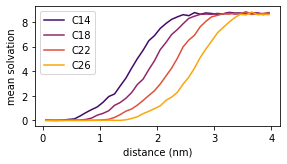

In [8]:
# make a plot of the solvatation profile for each simulation 
for sim in sims:
    if True:  #any(x in sim.dirname for x in selected_particles):
        try: 
            fig = sim.plot_mean_solv_profile(plt_label=sim.label)
        except:
            pass

fig.figure.set_size_inches([4.4,2.2])

fig.set_xlabel("distance (nm)")
fig.set_ylabel("mean solvation")
        
fig.figure.savefig("mean_solvation_profiles.png", dpi=150, bbox_inches='tight')

#fig.set_xlim([0.5,2.2])
#fig.set_ylim([-0.1, 8.0])
#fig.figure.savefig("mean_solvation_profiles_zoomin.png", dpi=150, bbox_inches='tight')


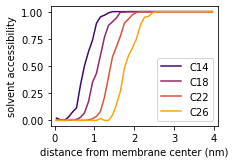

In [10]:
# make a plot of the solvatation profile for each simulation 
for sim in sims:
    if True:   #any(x in sim.dirname for x in selected_particles):
        try: 
            fig = sim.plot_mean_solv_profile(plt_label=sim.label, plt_solvdeg=True)
        except:
            pass

fig.figure.set_size_inches([3.0,2.2])
fig.set_xlabel("distance from membrane center (nm)")
fig.set_ylabel("solvent accessibility")

fig.set_xlim([-0.1, 4.1])
fig.figure.savefig("solvent_accessibility_profiles.png", dpi=150, bbox_inches='tight')


# I/O of the collected data

Save the list of Simulation class instances as a pickled object and
prepare a cell to load it again for later quick use. 

In [ ]:
# save the list of simulations
with open("mean_solvation_obj_list.pickle", 'bw') as picfile: 
    pickle.dump(sims, picfile)
    print("Saved the sims list to: ", picfile.name)
    

In [4]:
# read the list of Simulation class instances from a pickled file
with open("mean_solvation_obj_list.pickle", 'br') as picfile: 
    sims = pickle.load(picfile)
